In [5]:
import numpy as np
import setigen as stg
from astropy import units as u
import blimpy as bl
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats
from astropy.stats import sigma_clip
#import blscint as bs
%matplotlib inline

In [45]:
filename = '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
filename = '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5' # [5]

fb = bl.Waterfall(filename)

freqs, full_dynamic_spectrum = fb.grab_data()

dat_filename = '/datax/scratch/benjb/m31_l_data/' + filename[44:-2] + 'dat'

df = pd.read_table(dat_filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ctr_freqs = df['Uncorrected_Frequency'].values
drifts = df['Drift_Rate'].values

In [41]:
filename = '/datax/scratch/benjb/m31_observation_with_setigen.fil'

fb = bl.Waterfall(filename)

freqs, full_dynamic_spectrum = fb.grab_data()

In [6]:
def threshold_baseline_bounds(spec, p=0.01):
    """
    Create bounds based on integrated intensity on either side of the central
    peak, as a fraction of the peak integrated intensity. Uses a 1D fit to the
    noise baseline.
    
    Parameters
    ----------
    spec : ndarray
        Intensity spectra
    p : float, optional
        Fraction of peak, used to set left and right bounds
        
    Returns
    -------
    l : int
        Left bound
    r : int
        Right bound
    metadata : dict
        Dictionary with metadata. Contains noise mean and spectra maximum,
        which are used to normalize spec to the spectra maximum.
    """
    noise_spec = sigma_clip(spec, masked=True)
    x = np.arange(len(spec))

    coeffs = np.polyfit(x[~noise_spec.mask], noise_spec[~noise_spec.mask], 1)
    poly = np.poly1d(coeffs)
    
    spec = spec - poly(x)
    norm_spec = (spec ) / (np.max(spec) )
    
    cutoffs = np.where(norm_spec < p)[0]
    
    peak = np.argmax(norm_spec)
    i = np.digitize(peak, cutoffs) - 1
    # print(i, i+1, len(cutoffs), len(spec), cutoffs[-1])
    l, r = cutoffs[i] + 1, cutoffs[i + 1]
    
    metadata = {
        'noise_mean': np.mean(noise_spec),
        'spec_max': np.max(spec)
    }
    return l, r, metadata

In [47]:
caleb_wl = 0.0027

delta_f = 2.7939677238464355

sigbws = []

#ctr_freqs = np.array([1620.125632, 1598.326308, 1548.437656])
#drifts = np.array([-2.479634, 1.000017, 1.949013])

for ii, freq in enumerate(ctr_freqs):

    if (freq < 1590) or (freq > 1610):
        print(f'Not in satellite band; rejected.')
        continue

    if np.abs(drifts[ii]) > 3:  # ad hoc fix but oh well
        caleb_wl = 0.0054
    else:
        caleb_wl = 0.0027

    print(f'#{ii} of {len(ctr_freqs)}')

    dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+caleb_wl/2) & (freqs > freq-caleb_wl/2))[0]]



    frame = stg.Frame.from_data(df=delta_f*u.Hz,
                            dt=18.253611008*u.s,
                            fch1=(freq-caleb_wl/2)*u.MHz,
                            ascending=True, # fch1 is a minimum
                            data=dynamic_spectrum)
    
    #print(drifts[ii])
    dd_fr = stg.dedrift(frame, -drifts[ii]) # not sure why the negative is needed, but it works for me

    spec = stg.integrate(dd_fr)

    l, r, _ = threshold_baseline_bounds(spec)

    signal_bw = (float(r)-float(l))*delta_f
    sigbws.append(signal_bw)

    #break


#frame.plot(use_db=True)

#dd_fr.plot(use_db=True)
#print(f'{signal_bw} Hz')

Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in satellite band; rejected.
Not in sat

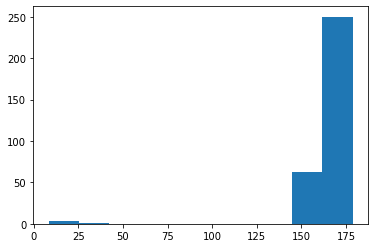

In [48]:
plt.hist(sigbws)
#plt.yscale('log')
plt.show()

In [49]:
np.savez('/datax/scratch/benjb/HIP3223_signal_bws.npz', sigbws)

In [ ]:
def dedrift(fr, drift_rate=None):
    
    """
    Dedrift frame with a provided drift rate, or with the "drift_rate"
    keyword in the frame's metadata. This function dedrifts with respect
    to the center of the frame, so signals at the edges may get cut off.
    
    Parameters
    ----------
    fr : Frame
        Input frame
    drift_rate : float, optional
        Drift rate in Hz/s
        
    Returns
    -------
    dr_fr : Frame
        De-drifted frame
    """

    if drift_rate is None:
        if 'drift_rate' in fr.metadata:
            drift_rate = fr.metadata['drift_rate']
        else:
            raise KeyError('Please specify a drift rate to account for')
            
    # Calculate maximum pixel offset and raise an exception if necessary
    max_offset = int(np.round(abs(drift_rate) * fr.tchans * fr.dt / fr.df))
    if max_offset >= fr.fchans:
        raise ValueError(f'The provided drift rate ({drift_rate:.2f} Hz/s) ' 
                         f'is too high for the frame dimensions')
    tr_data = np.zeros((fr.data.shape[0], fr.data.shape[1] - max_offset))

    for i in range(fr.tchans):
        offset = int(np.round(abs(drift_rate) * i * fr.dt / fr.df))
        if drift_rate >= 0:
            start_idx = 0 + offset
            end_idx = start_idx + tr_data.shape[1]
        else:
            end_idx = fr.data.shape[1] - offset
            start_idx = end_idx - tr_data.shape[1]
        tr_data[i] = fr.data[i, start_idx:end_idx]
        
    # Match frequency to truncated fr
    if fr.ascending:
        if drift_rate >= 0:
            fch1 = fr.fs[0]
        else:
            fch1 = fr.fs[max_offset]
    else:
        if drift_rate >= 0:
            fch1 = fr.fs[::-1][max_offset]
        else:
            fch1 = fr.fs[::-1][0]
        
    dd_fr = Frame.from_data(fr.df, 
                            fr.dt, 
                            fch1, 
                            fr.ascending,
                            tr_data,
                            metadata=fr.metadata,
                            waterfall=fr.check_waterfall())
#     if dd_fr.waterfall is not None and 'source_name' in dd_fr.waterfall.header:
#         dd_fr.waterfall.header['source_name'] += '_dedrifted'
    return dd_fr